In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import os
import pandas as pd
from itertools import product

from sklearn.preprocessing import LabelEncoder


from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import gc
from xgboost import plot_importance
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
pd.options.display.max_rows=150




In [2]:
import os
os.chdir('./src')


In [3]:
# use to save memory
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df


# input data

In [4]:
test=pd.read_csv('../inputs/test.csv')
sales_train=pd.read_csv('../inputs/sales_train.csv')
items=pd.read_csv('../inputs/items.csv')
item_categories=pd.read_csv('../inputs/item_categories.csv')
shops=pd.read_csv('../inputs/shops.csv')

# eda

In [5]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [6]:
sales_train.head()


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
# look at how many items and shops are in train and test  
test_item_unique=test['item_id'].unique()
test_shop_unique=test['shop_id'].unique()
    
train_item_unique=sales_train['item_id'].unique()
train_shop_unique=sales_train['shop_id'].unique()

print(test[test['item_id'].isin(train_item_unique)].shape[0]/test['item_id'].shape[0])
print(test[test['shop_id'].isin(train_shop_unique)].shape[0]/test['shop_id'].shape[0])

0.9288235294117647
1.0


In [8]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [9]:
item_categories.head()


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [10]:
shops.head()


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [11]:
# extract text features from items, item categories and shops

In [12]:
items['name_test'] = items['item_name'].str.split(' ').map(lambda x: x[0])
items['name_test'].unique().shape[0]
items['item_name_code'] = LabelEncoder().fit_transform(items['name_test'])
items=items[['item_id','item_category_id','item_name_code']]

item_categories.head()
item_categories['type'] = item_categories['item_category_name'].str.split(' ').map(lambda x: x[0])
item_categories['item_type_code'] = LabelEncoder().fit_transform(item_categories['type'])
item_categories=item_categories[['item_category_id','item_type_code']]

shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['shop_city_code'] = LabelEncoder().fit_transform(shops['city'])
shops=shops[['shop_id','shop_city_code']]    


In [13]:
# merge all data

In [14]:
train = pd.merge(sales_train, items, how='left', on='item_id')
train = pd.merge(train, item_categories, how='left', on='item_category_id')
train = pd.merge(train, shops, how='left', on='shop_id')

In [15]:
# boxplot of sales

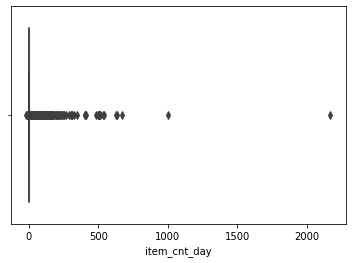

In [16]:
sns.boxplot(train['item_cnt_day'])


(array([2.93581e+06, 2.40000e+01, 1.10000e+01, 2.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ -22. ,  197.1,  416.2,  635.3,  854.4, 1073.5, 1292.6, 1511.7,
        1730.8, 1949.9, 2169. ]),
 <a list of 10 Patch objects>)

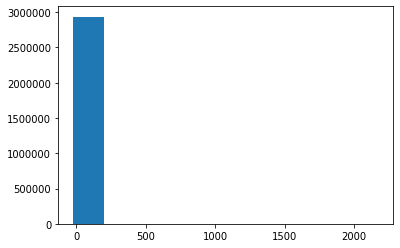

In [17]:
plt.hist(train['item_cnt_day'])

In [18]:
# data is very skewed but as instructed will clip later 

# feature engineering 

In [19]:
#create the training data- similar to the course 

index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales_train['date_block_num'].unique():
    cur_shops = sales_train[sales_train['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales_train[sales_train['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
    print(f'in monnth {block_num}, there were {len(cur_shops)} shops and {len(cur_items)} items')
    
#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

in monnth 0, there were 45 shops and 8115 items
in monnth 1, there were 46 shops and 8168 items
in monnth 2, there were 46 shops and 8302 items
in monnth 3, there were 46 shops and 8145 items
in monnth 4, there were 45 shops and 8339 items
in monnth 5, there were 46 shops and 8478 items
in monnth 6, there were 46 shops and 8405 items
in monnth 7, there were 45 shops and 8031 items
in monnth 8, there were 45 shops and 7876 items
in monnth 9, there were 46 shops and 8039 items
in monnth 10, there were 45 shops and 8089 items
in monnth 11, there were 46 shops and 8474 items
in monnth 12, there were 46 shops and 7551 items
in monnth 13, there were 46 shops and 7134 items
in monnth 14, there were 48 shops and 7142 items
in monnth 15, there were 49 shops and 6774 items
in monnth 16, there were 49 shops and 6685 items
in monnth 17, there were 49 shops and 6681 items
in monnth 18, there were 50 shops and 6611 items
in monnth 19, there were 51 shops and 6363 items
in monnth 20, there were 50 sh

In [20]:
# add test data
test['date_block_num']=34
grid=grid.append(test)
grid.drop('ID',axis=1,inplace=True)


/home/seth/anaconda3/envs/Test/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [21]:
# create the target and clip the data per the instructions 

#get aggregated values for (shop_id, item_id, month)
gb = sales_train.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]

all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)

all_data['target'] = all_data['target'].clip(0,20)


/home/seth/anaconda3/envs/Test/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


In [22]:
# add identifiers to the training data
all_data = pd.merge(all_data, items, how='left', on='item_id')
all_data = pd.merge(all_data, item_categories, how='left', on='item_category_id')
all_data = pd.merge(all_data, shops, how='left', on='shop_id')

In [23]:
# mean econding 

In [24]:
# add medians of some right skewed data 

gb = sales_train.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'median_item_cnt_month':'median'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data,gb,how='left',on=index_cols).fillna(0)


# Same as above but with item-price aggregates
gb = sales_train.groupby(index_cols,as_index=False).agg({'item_price':{'target_price':'median'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data,gb,how='left',on=index_cols).fillna(0)





In [25]:
# add monthly trend 
gb = train.groupby([ 'date_block_num'],as_index=False).agg({'item_cnt_day':{'date_block_mean':'mean'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['date_block_num']).fillna(0)

In [26]:
# get means and sum of identifier items on a month basis  
agg_cols=['shop_id','item_id','item_category_id','item_name_code','item_type_code']
agg_ops=['sum','mean']


for agg_op in agg_ops:
    for agg_col in agg_cols:
        print(agg_col+ " "+ agg_op)
        gb = train.groupby([agg_col, 'date_block_num'],as_index=False).agg({'item_cnt_day':{agg_col+agg_op:agg_op}})
        gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
        all_data = pd.merge(all_data, gb, how='left', on=[agg_col, 'date_block_num']).fillna(0)


all_data.rename(columns={'shop_idsum':'target_shop_sum', 
                        'item_idsum':'target_id_sum', 
                        'item_category_idsum':'target_category_sum', 
                        'item_name_codesum': 'target_namecode_sum', 
                        'item_type_codesum': 'target_typecode_sum', 
                        'shop_idmean':'target_shop_mean', 
                        'item_idmean':'target_id_mean', 
                        'item_category_idmean':'target_category_mean',
                        'item_name_codemean': 'target_namecode_mean', 
                        'item_type_codemean': 'target_typecode_mean', 
                        })
all_data = downcast_dtypes(all_data)


shop_id sum
item_id sum
item_category_id sum
item_name_code sum
item_type_code sum
shop_id mean
item_id mean
item_category_id mean
item_name_code mean
item_type_code mean


In [27]:
# lag features 

In [28]:
cols_for_lag=['date_block_mean',
                'item_category_idmean',
                'item_category_idsum',
                'item_idmean',
                'item_idsum',
                'item_name_codemean',
                'item_name_codesum',
                'item_type_codemean',
                'item_type_codesum',
                'median_item_cnt_month',
                'shop_idmean',
                'shop_idsum',
                'target',
                'target_price']

shift_range = [1,2,3,6,12]

for month_shift in shift_range:
    print(month_shift)
    train_shift = all_data[index_cols + cols_for_lag].copy()

    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift

    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_for_lag else x
    train_shift = train_shift.rename(columns=foo)
    train_shift=downcast_dtypes(train_shift)
    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)


    del train_shift

1
2
3
6
12


In [29]:
# drop mean encoded for the current month, use lags onl7
all_data = downcast_dtypes(all_data)


to_drop=['item_category_idmean',
        'item_category_idsum',
        'item_idmean',
        'item_idsum',
        'item_name_codemean',
        'item_name_codesum',
        'item_type_codesum',
        'item_type_codemean',
        'shop_idmean',
        'shop_idsum',
        'target_price',
        'median_item_cnt_month',
        'date_block_mean',
        ]


all_data=all_data.drop(to_drop,axis=1)


In [30]:
# add some averages
all_data['target_2mavg']=(all_data['target_lag_1']
                        +all_data['target_lag_2']
                        )/2

all_data['target_3mavg']=(all_data['target_lag_1']
                        +all_data['target_lag_2']
                        +all_data['target_lag_3'])/3

all_data['target_6mavg']=(all_data['target_lag_1']
                        +all_data['target_lag_2']
                        +all_data['target_lag_3']
                        +all_data['target_lag_6'])/4




In [31]:
# add the month
all_data['month'] = all_data['date_block_num'] % 12

In [32]:
# drop all lags before 12 
all_data = all_data[all_data['date_block_num'] >= 12] 


In [33]:
all_data.head(5).T

,4488756,4488757,4488758,4488759,4488760
date_block_num,12.000000,12.000000,12.000000,12.000000,12.000000
item_id,10297.000000,10296.000000,10298.000000,10300.000000,10284.000000
shop_id,54.000000,54.000000,54.000000,54.000000,54.000000
target,4.000000,3.000000,14.000000,3.000000,1.000000
item_category_id,37.000000,38.000000,40.000000,37.000000,57.000000
item_name_code,2153.000000,2153.000000,2153.000000,2153.000000,2150.000000
item_type_code,7.000000,7.000000,7.000000,7.000000,9.000000
shop_city_code,27.000000,27.000000,27.000000,27.000000,27.000000
date_block_mean_lag_1,1.279910,1.279910,1.279910,1.279910,1.279910
item_category_idmean_lag_1,1.049310,1.018868,1.163135,1.049310,1.016405


# cross validation strategy 

In [34]:
# train 12-32, validate 33, predict 34
def train_val_test_split(data,lag=12,
                    to_drop_cols=['target']):
    data = data[data['date_block_num'] >= 12] 
    # Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
    dates = data['date_block_num']

    last_block = dates.max()
    print('Test `date_block_num` is %d' % last_block)


    dates_train = dates[dates <  last_block]
    dates_test  = dates[dates == last_block]

    X_train = data.loc[dates <  last_block-1].drop(to_drop_cols, axis=1)
    X_val = data.loc[dates ==  last_block-1].drop(to_drop_cols, axis=1)
    X_test =  data.loc[dates == last_block].drop(to_drop_cols, axis=1)
    y_train = data.loc[dates <  last_block-1, 'target'].values
    y_val =  data.loc[dates == last_block-1, 'target'].values

    return X_train,X_val,X_test,y_train,y_val


In [35]:
X_train,X_val,X_test,y_train,y_val=train_val_test_split(all_data)


Test `date_block_num` is 34


# hyperparamter optimization

In [36]:
# attempt to use hyperopt on xgboost 

"""
space={ 'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', .1,.9),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 100, 1000, 100),
        'eta': hp.uniform ('eta', .1,.4),
        'n_estimators': 100,"subsample":.8 }


def hyperparameter_tuning(space):
    reg=xgb.XGBRegressor(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), 
                        gamma = space['gamma'],eta = space['eta'],
                        min_child_weight=space['min_child_weight'],
                        colsample_bytree=space['colsample_bytree'])
    
    evaluation = [(X_train, y_train), (X_val, y_val)]
    
    reg.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = reg.predict(X_val)
    mse= mean_squared_error(y_val, pred)
    print ("SCORE:", mse)
    #change the metric if you like
    return {'loss':mse, 'status': STATUS_OK }






trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

"""


'\nspace={ \'max_depth\': hp.quniform("max_depth", 3, 18, 1),\n        \'gamma\': hp.uniform (\'gamma\', .1,.9),\n        \'colsample_bytree\' : hp.uniform(\'colsample_bytree\', 0.5,1),\n        \'min_child_weight\' : hp.quniform(\'min_child_weight\', 100, 1000, 100),\n        \'eta\': hp.uniform (\'eta\', .1,.4),\n        \'n_estimators\': 100,"subsample":.8 }\n\n\ndef hyperparameter_tuning(space):\n    reg=xgb.XGBRegressor(n_estimators =space[\'n_estimators\'], max_depth = int(space[\'max_depth\']), \n                        gamma = space[\'gamma\'],eta = space[\'eta\'],\n                        min_child_weight=space[\'min_child_weight\'],\n                        colsample_bytree=space[\'colsample_bytree\'])\n    \n    evaluation = [(X_train, y_train), (X_val, y_val)]\n    \n    reg.fit(X_train, y_train,\n            eval_set=evaluation, eval_metric="rmse",\n            early_stopping_rounds=10,verbose=False)\n\n    pred = reg.predict(X_val)\n    mse= mean_squared_error(y_val, pred

# model fitting 

In [37]:
# xgboost model using regsquare error which will minimize 

In [38]:
#use rounded hyperparms
xgboost_params = {
             "eta"              : .35,
            "max_depth"         : 8,
            "min_child_weight" : 500,
            "gamma"            : .1,
            "n_estimators"     : 50,
            "colsample_bytree"  : .6,
            "subsample"    :.8 
              }


model_xgb=xgb.XGBRegressor(**xgboost_params,random_state=1)

In [39]:
model_xgb.fit(X_train,y_train)


[16:48:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1584539733809/work/src/gbm/gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eta=0.35, gamma=0.1,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.349999994, max_delta_step=0, max_depth=8,
             min_child_weight=500, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=1, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
             validate_parameters=False, verbosity=None)

In [40]:
xgboost_val_pred = model_xgb.predict(X_val)
xgboost_test_pred = model_xgb.predict(X_test)

In [41]:
# KNN model 

In [43]:
knn_features=['date_block_num', 'item_id', 'shop_id', 'item_category_id',
       'item_name_code', 'item_type_code', 'shop_city_code',
       'target_lag_1', 'target_price_lag_1','month']

In [77]:
X_train_knn=X_train[knn_features]
X_train_knn.reset_index(inplace=True,drop=True)

In [78]:
X_train_knn=X_train_knn[X_train_knn['date_block_num']>30]


In [82]:
y_train_knn=y_train[X_train_knn.index]

In [49]:
scaler = StandardScaler()
X_train_scale=scaler.fit_transform(X_train_knn)

In [83]:
neigh = KNeighborsRegressor(n_neighbors=2,n_jobs=-1)
neigh.fit(X_train_scale, y_train_knn)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
                    weights='uniform')

In [85]:
knn_val_pred=neigh.predict(scaler.transform(X_val[knn_features]))
knn_test_pred=neigh.predict(scaler.transform(X_test[knn_features]))

# linear ensembles on validation predictions 

In [86]:
X_pred_df=pd.DataFrame({'xgb':xgboost_val_pred,'knn':knn_val_pred})
X_test_df=pd.DataFrame({'xgb':xgboost_test_pred,'knn':knn_test_pred})

In [87]:
stack=LinearRegression()

stack.fit(X_pred_df, y_val)
stack_pred_val=stack.predict(X_pred_df)

stack.coef_
mean_squared_error(y_val, stack_pred_val)**.5

0.9296618546226524

In [90]:
stack.coef_


array([0.81964374, 0.10156324], dtype=float32)

In [95]:
import pickle

filename = 'finalized_model.sav'
pickle.dump(stack, open(filename, 'wb'))

# Final Predictions

In [89]:
test_pred=stack.predict(X_test_df)

In [91]:
submission = pd.DataFrame({
    "ID": X_test.index,
    "item_id": X_test['item_id'],
    "shop_id": X_test['shop_id'],  
    "item_cnt_month": test_pred
    })

submission["item_cnt_month"]=submission["item_cnt_month"].clip(0,20)
test=pd.read_csv('../inputs/test.csv')
submission=pd.merge(test,submission[['item_id','shop_id','item_cnt_month']],on=['item_id','shop_id'])
submission[['ID','item_cnt_month']].to_csv('../predictions/xgboost_model_new_model_simplestack.csv',index=False)